In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
eur = pd.read_excel('eur_rub_2012-2017_hours.xls', index_col = [0, 1])
print(eur.head())

                       Close
Date       Time             
2012-01-02 02:00:00  41.6471
           03:00:00  41.6490
           04:00:00  41.6711
           05:00:00  41.6456
           06:00:00  41.6198


In [9]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [10]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [11]:
eur_np_array = eur.values
eur_np_array = eur_np_array.astype('float32')

In [12]:
eur_np_array

array([[ 41.64709854],
       [ 41.64899826],
       [ 41.67110062],
       ..., 
       [ 69.15820312],
       [ 69.18900299],
       [ 69.20999908]], dtype=float32)

In [13]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
eur_normalized_np_array = scaler.fit_transform(eur_np_array)

In [14]:
eur_normalized_np_array[:5]

array([[ 0.05758905],
       [ 0.05762208],
       [ 0.05800629],
       [ 0.05756301],
       [ 0.05711454]], dtype=float32)

In [15]:
# split into train and test sets
dataset = eur_normalized_np_array
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

30542 7636


In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [18]:
trainX[-1:]

array([[[ 0.50745696],
        [ 0.50664014],
        [ 0.50597948]]], dtype=float32)

In [19]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=batch_size, verbose=2, shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/100
 - 82s - loss: 6.6240e-05
Epoch 2/100
 - 74s - loss: 1.0759e-04
Epoch 3/100
 - 81s - loss: 9.8582e-05
Epoch 4/100
 - 101s - loss: 8.3702e-05
Epoch 5/100
 - 74s - loss: 6.5290e-05
Epoch 6/100
 - 74s - loss: 5.1291e-05
Epoch 7/100
 - 75s - loss: 5.1084e-05
Epoch 8/100
 - 76s - loss: 4.7003e-05
Epoch 9/100
 - 74s - loss: 4.5323e-05
Epoch 10/100
 - 74s - loss: 4.5132e-05
Epoch 11/100
 - 74s - loss: 4.2655e-05
Epoch 12/100
 - 74s - loss: 5.6598e-05
Epoch 13/100
 - 74s - loss: 6.8853e-05
Epoch 14/100
 - 75s - loss: 7.5040e-05
Epoch 15/100
 - 74s - loss: 8.3159e-05
Epoch 16/100
 - 74s - loss: 8.8631e-05
Epoch 17/100
 - 74s - loss: 8.7937e-05
Epoch 18/100
 - 74s - loss: 6.8889e-05
Epoch 19/100
 - 75s - loss: 4.8350e-05
Epoch 20/100
 - 74s - loss: 6.8372e-05
Epoch 21/100
 - 74s - loss: 6.1016e-05
Epoch 22/100
 - 75s - loss: 5.4661e-05
Epoch 23/100
 - 74s - loss: 5.1886e-05
Epoch 24/100
 - 75s - loss: 5.4240e-05
Epoch 25/100
 - 75s - loss: 4.5284e-05
Epoch 26/100
 - 74s - loss: 5.115

In [20]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.49 RMSE
Test Score: 1.49 RMSE


In [21]:
dataset = eur_normalized_np_array

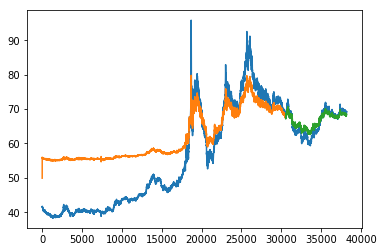

In [23]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
trainPredictPlot[:10]

array([[         nan],
       [         nan],
       [         nan],
       [ 49.8978653 ],
       [ 49.93971634],
       [ 50.37691879],
       [ 53.21986008],
       [ 56.00883484],
       [ 55.87433243],
       [ 55.84125519]], dtype=float32)

In [25]:
scaler.inverse_transform(dataset)[:10]

array([[ 41.64709854],
       [ 41.64899826],
       [ 41.67110062],
       [ 41.64559937],
       [ 41.61980057],
       [ 41.61989975],
       [ 41.60380173],
       [ 41.61750031],
       [ 41.62739944],
       [ 41.61439896]], dtype=float32)

In [26]:
len(testPredict)

7632

In [27]:
prediction = testPredict[-6432:]

In [28]:
real = testY[0][-6432:]

In [29]:
eur = pd.read_csv('data.csv', header=0, index_col=['Date', 'Time'])
print(eur.head())

predictions = pd.DataFrame(index=eur.index)
predictions['real'] = real
predictions['prediction'] = prediction

                  Close
Date     Time          
1/1/2017 22:00  64.3460
         23:00  64.3580
2/1/2017 0:00   64.3610
         1:00   64.7335
         2:00   64.7369


In [30]:
predictions.to_excel('predictions.xlsx')

In [29]:
print(len(prediction))

5098


In [67]:
len(testPredict)

8413